# final reconstructions

In [ ]:
import h5py
import numpy as np
import data.transforms as T
from matplotlib import pyplot as plt
import torch
import matplotlib.gridspec as gridspec

In [ ]:
fname = 'e15790s3_P01536.7.h5'
data_path = "/media/student1/RemovableVolume/calgary_new/Test/test_12_channel/Test-R=5/" + fname
slice = 120
with h5py.File(data_path, 'r') as data:

    zf_kspace = data['kspace'][()]
    mask_sampling = ~( np.abs(zf_kspace).sum( axis = (0, -1) ) == 0)
    mask_np = 1.0*mask_sampling
    ksp = zf_kspace[slice+50]


ksp_cmplx = ksp[:,:,::2] + 1j*ksp[:,:,1::2]
ksp_t = T.to_tensor(ksp_cmplx)
ksp_us= ksp_t.permute(2,0,1,3)
img_us = T.ifft2(ksp_us)
img_us_np = T.root_sum_of_squares(T.complex_abs(T.ifft2(ksp_us)))
img_us_np.shape

In [ ]:
VOLUME = '5'
recons_path = '/media/student1/RemovableVolume/calgary_new/rotnet/'+ VOLUME +'_volume/Track01/12-channel-R=5/'+fname
with h5py.File(recons_path, 'r') as data:

    out = data['reconstruction'][()]
print("out=",out.shape)
out = out[slice,0,:,:]
# out.shape  

In [ ]:
plt.figure(figsize=(10,10))
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
plt.imshow(img_us_np,cmap='gray')
plt.colorbar()

plt.subplot(gs1[1])
plt.imshow(out,cmap='gray')
plt.colorbar()

# check model recons

In [ ]:
import h5py
import numpy as np
import data.transforms as T
from matplotlib import pyplot as plt
import torch
import matplotlib.gridspec as gridspec

In [ ]:
VOLUME = '20'
ACTION = 'finetune'
PRETEXT = 'rotnet'

checkpoint_file = "/media/student1/NewVolume/MR_Reconstruction/experiments/midl/varnet_unet/12-channels/" + PRETEXT + "/" + ACTION +"/acc_5x/0_layer/0.001_lr/" + VOLUME + "_volume/best_model.pt"
data_path = "/media/student1/RemovableVolume/calgary_new/Test/test_12_channel/Test-R=5/e15274s3_P20992.7.h5"
slice = 150

In [ ]:
def DataTransform(ksp,mask,fname,slice):

    mask = torch.from_numpy(mask)
    mask = (torch.stack((mask,mask),dim=-1)).float()

    ksp_cmplx = ksp[:,:,::2] + 1j*ksp[:,:,1::2]


    ksp_t = T.to_tensor(ksp_cmplx)
    ksp_us= ksp_t.permute(2,0,1,3)

    img_us = T.ifft2(ksp_us)

    img_us_rss = T.root_sum_of_squares(T.complex_abs(T.ifft2(ksp_us)))
    maxi = img_us_rss.max().float()


    return ksp_us.unsqueeze(0)/maxi ,  img_us.unsqueeze(0)/maxi , img_us_rss.unsqueeze(0)/maxi  , mask.unsqueeze(0), fname, slice,maxi.unsqueeze(0)

In [ ]:
with h5py.File(data_path, 'r') as data:

    zf_kspace = data['kspace'][()]
    mask_sampling = ~( np.abs(zf_kspace).sum( axis = (0, -1) ) == 0)
    mask_np = 1.0*mask_sampling
    ksp = zf_kspace[slice]


ksp_us,img_us,img_us_rss,mask, fname, slice,maxi = DataTransform(ksp, mask_np,data_path,slice)

 

In [ ]:
from models.models import  architecture_unet
def build_model(args):
    
    wacoeff = 0.1
    dccoeff = 0.1
    cascade = args.cascade   
    sens_chans = 8
    sens_pools = 4

    model = architecture_unet(dccoeff, wacoeff, cascade,sens_chans, sens_pools).cuda()


    return  model 



In [ ]:
checkpoint = torch.load(checkpoint_file)
args = checkpoint['args']
model = build_model(args)
model.load_state_dict(checkpoint['model'])

In [ ]:
ksp_us = ksp_us.cuda()
img_us = img_us.cuda()

mask = mask.cuda()
maxi = maxi.float().cuda()

out,_,_ = model(img_us,ksp_us,mask)

In [ ]:
plt.figure(figsize=(10,10))
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
plt.imshow(img_us_rss[0]*maxi.cpu()/100.0,cmap='gray')
plt.colorbar()

plt.subplot(gs1[1])
plt.imshow(out[0,0,:,:].detach().cpu()*maxi.cpu()/100.0,cmap='gray')
plt.colorbar()

# check on validation data

In [ ]:
fname = "/media/student1/RemovableVolume/calgary/Train/e15828s13_P65536.7.100.h5"
import random
acceleration=5
with h5py.File(fname, 'r') as data:

    ksp = data['kspace'][()]
    sens = data['sensitivity'][()]
    

In [ ]:
def DataTransform(ksp_cmplx,fname,sensitivity,acceleration):
    """
    Args:
        ksp_cmplx (numpy.array): Input k-space of the multi-coil data
        fname (str): File name
        sensitivity(numpy.array): ENLIVE sensitivity maps
        acceleartion: whether to train for 5x US ksp or 10x US kspace

    """

    sens_t = T.to_tensor(sensitivity)
    ksp_t = T.to_tensor(ksp_cmplx)
    ksp_t = ksp_t.permute(2,0,1,3)

    img_gt_np = T.root_sum_of_squares(T.complex_abs(T.ifft2_np(ksp_t)))


    if acceleration == 5:

        if ksp_t.shape[2]==170:
            sp_r5 = np.load("/media/student1/NewVolume/MR_Reconstruction/midl/MC-MRRec-challenge/Data/poisson_sampling/R5_218x170.npy")
        elif ksp_t.shape[2]==174:
            sp_r5 = np.load("/media/student1/NewVolume/MR_Reconstruction/midl/MC-MRRec-challenge/Data/poisson_sampling/R5_218x174.npy")
        elif ksp_t.shape[2]==180:
            sp_r5 = np.load("/media/student1/NewVolume/MR_Reconstruction/midl/MC-MRRec-challenge/Data/poisson_sampling/R5_218x180.npy")

    elif acceleration == 10:

        if ksp_t.shape[2]==170:
            sp_r5 = np.load("/media/student1/NewVolume/MR_Reconstruction/midl/MC-MRRec-challenge/Data/poisson_sampling/R10_218x170.npy")
        elif ksp_t.shape[2]==174:
            sp_r5 = np.load("/media/student1/NewVolume/MR_Reconstruction/midl/MC-MRRec-challenge/Data/poisson_sampling/R10_218x174.npy")
        elif ksp_t.shape[2]==180:
            sp_r5 = np.load("/media/student1/NewVolume/MR_Reconstruction/midl/MC-MRRec-challenge/Data/poisson_sampling/R10_218x180.npy")



    randint = random.randint(0,99)                   #to get a random mask everytime ! 
    mask = sp_r5[randint]
    mask = torch.from_numpy(mask)
    mask = (torch.stack((mask,mask),dim=-1)).float()

    ksp_us = torch.where(mask == 0, torch.Tensor([0]), ksp_t)

    img_us_np = T.root_sum_of_squares(T.complex_abs(T.ifft2_np(ksp_us)))
    img_us = T.ifft2(ksp_us)
    img_us_rss = T.root_sum_of_squares(T.complex_abs(T.ifft2(ksp_us)))


    maxi = img_us_rss.max().float()

    return   ksp_us.unsqueeze(0)/maxi ,  img_us.unsqueeze(0)/maxi  , img_us_rss.unsqueeze(0)/maxi , 100.0*img_us_np.unsqueeze(0)/maxi , 100.0*img_gt_np.unsqueeze(0)/maxi ,sens_t.unsqueeze(0), mask.unsqueeze(0) ,maxi.unsqueeze(0),fname

In [ ]:
ksp_us, img_us, img_us_rss,img_us_np,img_gt_np,sens_t, mask ,maxi,fname = DataTransform(ksp, fname, sens, acceleration)

In [ ]:
VOLUME = '20'
ACTION = 'finetune'
PRETEXT = 'rotnet'

checkpoint_file = "/media/student1/NewVolume/MR_Reconstruction/experiments/midl/varnet_unet/12-channels/" + PRETEXT + "/" + ACTION +"/acc_5x/0_layer/0.001_lr/" + VOLUME + "_volume/best_model.pt"
data_path =  "/media/student1/RemovableVolume/calgary/Val/e14264s3_P08192.7.126.h5"

In [ ]:
from models.models import  architecture_unet
def build_model(args):
    
    wacoeff = 0.1
    dccoeff = 0.1
    cascade = args.cascade   
    sens_chans = 8
    sens_pools = 4

    model = architecture_unet(dccoeff, wacoeff, cascade,sens_chans, sens_pools).cuda()


    return  model 


In [ ]:
checkpoint = torch.load(checkpoint_file)
args = checkpoint['args']
model = build_model(args)
model.load_state_dict(checkpoint['model'])

In [ ]:
ksp_us = ksp_us.cuda()
img_us = img_us.cuda()

mask = mask.cuda()
maxi = maxi.float().cuda()

out,_,_ = model(img_us,ksp_us,mask)

In [ ]:
plt.figure(figsize=(10,10))
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
plt.imshow(img_us_rss[0]*maxi.cpu()/100.0,cmap='gray')
plt.colorbar()

plt.subplot(gs1[1])
plt.imshow(out[0,0,:,:].detach().cpu()*maxi.cpu()/100.0,cmap='gray')
plt.colorbar()

# model reconstructions on validation data 
# finding SSIM and PSNR values

In [4]:
import h5py
import numpy as np
import data.transforms as T
from matplotlib import pyplot as plt
import torch
import matplotlib.gridspec as gridspec
import random

In [2]:
from models.models import UnetModel, network, SSIM ,SensitivityModel, architecture_unet, change_init
def build_model(args):
    
    wacoeff = 0.1
    dccoeff = 0.1
    cascade = 12 #args.cascade   
    sens_chans = 8
    sens_pools = 4

    model = architecture_unet(dccoeff, wacoeff, cascade,sens_chans, sens_pools)


    return  model 

def load_model(checkpoint_file,layer_init = 0):

    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model_ori = build_model(args)
    if args.data_parallel:

        model = torch.nn.DataParallel(model)

    model_ori.load_state_dict(checkpoint['model'])

    # optimizer = build_optim((model_ori.parameters()),args.lr,args.weight_decay)

    # optimizer.load_state_dict(checkpoint['optimizer'])
    
    model_rand = build_model(args)

    model_ori = change_init(model_ori,model_rand , layer_init).to(args.device)
    
    
    return  model_ori 


In [13]:
import numpy as np
import h5py
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from sewar.full_ref import vifp

def metrics(rec,ref):
    print("rec=",np.max(rec),"ref=",np.max(ref))
    ssim = np.zeros(rec.shape[0])
    psnr = np.zeros(rec.shape[0])
    vif = np.zeros(rec.shape[0])
    
    for ii in range(rec.shape[0]):
        data_range = np.maximum(ref[ii].max(),rec[ii].max()) - np.minimum(ref[ii].min(),rec[ii].min())
        ssim[ii] = structural_similarity(ref[ii],rec[ii],data_range= data_range)
        psnr[ii] = peak_signal_noise_ratio(ref[ii],rec[ii],data_range= data_range)
        vif[ii] =  vifp(ref[ii],rec[ii],sigma_nsq = 0.4)

    return ssim,psnr,vif

In [5]:
checkpoint_file_s = "/media/student1/NewVolume/MR_Reconstruction/experiments/midl/varnet_unet/12-channels/autoencoder/scratch/acc_5x/5_volume/12_cascade/0.001_lr/best_model.pt"
checkpoint_file_f = "/media/student1/NewVolume/MR_Reconstruction/experiments/midl/varnet_unet/12-channels/autoencoder/finetune/acc_5x/0_layer/0.001_lr/5_volume/best_model.pt"
model_s= load_model(checkpoint_file_s)
model_f= load_model(checkpoint_file_f)

In [56]:
slice= 115
s = 'e14264s3_P08192.7.'+str(slice)+'.h5'
fname = "/media/student1/RemovableVolume/calgary/Val/" + s

with h5py.File(fname, 'r') as data:

    ksp_cmplx = data['kspace'][()]
    sensitivity = data['sensitivity'][()]


sens_t = T.to_tensor(sensitivity)
ksp_t = T.to_tensor(ksp_cmplx)
ksp_t = ksp_t.permute(2,0,1,3)

img_gt_np2 = T.root_sum_of_squares(T.complex_abs(T.ifft2_np(ksp_t)))


acceleration =5

if ksp_t.shape[2]==170:
    sp_r5 = np.load("/media/student1/NewVolume/MR_Reconstruction/midl/MC-MRRec-challenge/Data/poisson_sampling/R5_218x170.npy")
elif ksp_t.shape[2]==174:
    sp_r5 = np.load("/media/student1/NewVolume/MR_Reconstruction/midl/MC-MRRec-challenge/Data/poisson_sampling/R5_218x174.npy")
elif ksp_t.shape[2]==180:
    sp_r5 = np.load("/media/student1/NewVolume/MR_Reconstruction/midl/MC-MRRec-challenge/Data/poisson_sampling/R5_218x180.npy")

randint = random.randint(0,99)                   #to get a random mask everytime ! 
mask = sp_r5[randint]
mask = torch.from_numpy(mask)
mask = (torch.stack((mask,mask),dim=-1)).float()

ksp_us = torch.where(mask == 0, torch.Tensor([0]), ksp_t)

img_us_np2 = T.root_sum_of_squares(T.complex_abs(T.ifft2_np(ksp_us)))
img_us = T.ifft2(ksp_us)
img_us_rss = T.root_sum_of_squares(T.complex_abs(T.ifft2(ksp_us)))

maxi = img_us_rss.max().float()

ksp_us = ksp_us.unsqueeze(0)/maxi 
img_us = img_us.unsqueeze(0)/maxi  
img_us_rss = img_us_rss.unsqueeze(0)/maxi 
img_us_np = 100.0*img_us_np2.unsqueeze(0)/maxi 
img_gt_np = 100.0*img_gt_np2.unsqueeze(0)/maxi

In [57]:
ksp_us = ksp_us.cuda()
# sens = sens.to(args.device)
mask = mask.cuda()
img_us = img_us.cuda()
# img_gt = img_gt.to(args.device)
img_gt_np = img_gt_np.unsqueeze(0).cuda().float()
img_us_np = img_us_np.unsqueeze(0).cuda().float()

out_s,_,_ = model_s(img_us,ksp_us,mask)
out_f,_,_ = model_f(img_us,ksp_us,mask)
error_s = torch.abs(out_s-img_gt_np)
error_f = torch.abs(out_f-img_gt_np)

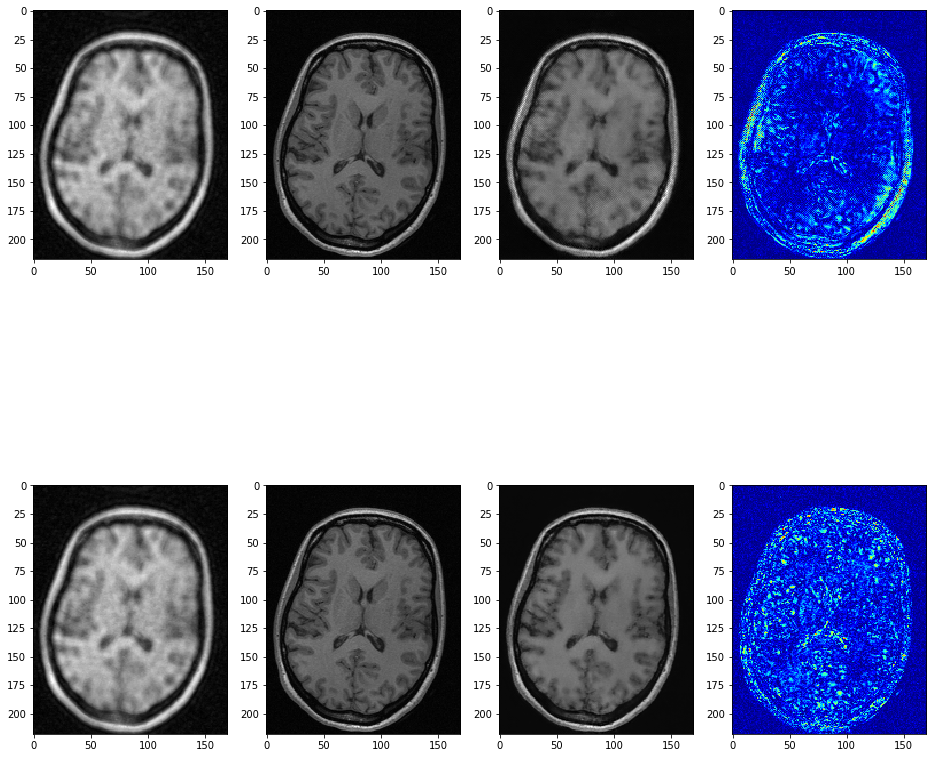

In [58]:
fig=plt.figure(figsize=(16, 16))
fig.add_subplot(2, 4, 1)
plt.imshow(img_us_np[0,0,:,:].detach().cpu(),cmap='gray')
fig.add_subplot(2, 4, 2)
plt.imshow(img_gt_np[0,0,:,:].detach().cpu(),cmap='gray')
fig.add_subplot(2, 4, 3)
plt.imshow(out_s[0,0,:,:].detach().cpu(),cmap='gray')
fig.add_subplot(2, 4, 4)
plt.imshow(error_s[0,0,:,:].detach().cpu(),cmap='jet')

fig.add_subplot(2, 4, 5)
plt.imshow(img_us_np[0,0,:,:].detach().cpu(),cmap='gray')
fig.add_subplot(2, 4, 6)
plt.imshow(img_gt_np[0,0,:,:].detach().cpu(),cmap='gray')
fig.add_subplot(2, 4, 7)
plt.imshow(out_f[0,0,:,:].detach().cpu(),cmap='gray')
fig.add_subplot(2, 4, 8)
plt.imshow(error_f[0,0,:,:].detach().cpu(),cmap='jet')

In [59]:
fname = "/media/student1/RemovableVolume/calgary/Val/" + s

with h5py.File(fname, 'r') as data:

    ksp = data['kspace'][()]
ksp_t = T.to_tensor(ksp)
ksp_t = ksp_t.permute(2,0,1,3)

img_gt_np = T.root_sum_of_squares(T.complex_abs(T.ifft2_np(ksp_t)))
img_gt_np.shape

out_s = out_s.float()*maxi/100.0
out_f = out_f.float()*maxi/100.0

In [60]:

ref_max = img_gt_np2.cpu().numpy().max()
# print(ref_max)
ref = img_gt_np2.cpu().numpy()/ref_max

out_u = img_us_np2.unsqueeze(0).unsqueeze(0)

rec_u = out_u[0,0,:,:].detach().cpu().numpy()/ref_max
rec_s = out_s[0,0,:,:].detach().cpu().numpy()/ref_max
rec_f = out_f[0,0,:,:].detach().cpu().numpy()/ref_max

ssim_u,psnr_u,vif_u = metrics(np.expand_dims(rec_u,0),np.expand_dims(ref,0))
ssim_s,psnr_s,vif_s = metrics(np.expand_dims(rec_s,0),np.expand_dims(ref,0))
ssim_f,psnr_f,vif_f = metrics(np.expand_dims(rec_f,0),np.expand_dims(ref,0))

print("US= ssim=",ssim_u,"psnr=",psnr_u,"vif=",vif_u)
print("SCRATCH= ssim=",ssim_s,"psnr=",psnr_s,"vif=",vif_s)
print("FINETUNE= ssim=",ssim_f,"psnr=",psnr_f,"vif=",vif_f)

rec= 0.58193797 ref= 1.0
rec= 0.932495 ref= 1.0
rec= 0.94744515 ref= 1.0
US= ssim= [0.77756928] psnr= [26.18698083] vif= [0.51715719]
SCRATCH= ssim= [0.8066175] psnr= [26.07004161] vif= [1.02885485]
FINETUNE= ssim= [0.89582293] psnr= [31.41189491] vif= [0.97996309]
